In [84]:
import h2o
import pandas as pd

In [7]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.25-b02, mixed mode)
  Starting server from C:\Users\MSI\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\MSI\AppData\Local\Temp\tmp4lhhj71o
  JVM stdout: C:\Users\MSI\AppData\Local\Temp\tmp4lhhj71o\h2o_Chris_started_from_python.out
  JVM stderr: C:\Users\MSI\AppData\Local\Temp\tmp4lhhj71o\h2o_Chris_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Africa/Harare
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_Chris_qct3a1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.523 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


#### Import data

In [8]:
# ext_url = "https://storage.googleapis.com/bdt-spark-store/external_sources.csv"
ext_url = "external_sources.csv"
ext_df = h2o.import_file(path=ext_url)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
# data_url = "https://storage.googleapis.com/bdt-spark-store/internal_data.csv"
data_url = "internal_data.csv"
data_df = h2o.import_file(path=data_url)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Merge Datasets

In [97]:
df_full = data_df.merge(ext_df)

#### Filter for columns required

In [98]:
columns_extract = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE',
                  'DAYS_ID_PUBLISH', 'CODE_GENDER', 'AMT_ANNUITY',
                  'DAYS_REGISTRATION', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
                  'ORGANIZATION_TYPE', 'DAYS_LAST_PHONE_CHANGE',
                  'NAME_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'OWN_CAR_AGE', 'TARGET']
df = df_full[columns_extract]

#### Set Target variable as categorical

In [99]:
df['TARGET'] = df['TARGET'].asfactor()

#### Split into test and train

In [100]:
train, test = df.split_frame(ratios=[.8], seed=101)

#### Calculate target variable proportions in each set

In [101]:
train_prop = train['TARGET'].table()
train_prop['Count'] = train_prop['Count'] / train.shape[0]
train_prop = train_prop.rename(columns={'Count': 'Proportion'})

test_prop = test['TARGET'].table()
test_prop['Count'] = test_prop['Count'] / test.shape[0]
test_prop = test_prop.rename(columns={'Count': 'Proportion'})

print(train_prop)
print(test_prop)

TARGET,Proportion
0,0.919514
1,0.0804857


TARGET,Proportion
0,0.918295
1,0.0817045


#### Impute Missing Values

In [102]:
train.impute(method = "median")
test.impute(method = "median")
print("Missing values in train set: ", train.isna().sum())
print("Missing values in test set: ", test.isna().sum())

Missing values in train set:  0.0
Missing values in test set:  0.0


#### Feature scaling

##### H2O does not offer feature scaling for random forest

#### Train Random Forest Classifier

In [103]:
from h2o.estimators import H2ORandomForestEstimator

rf = H2ORandomForestEstimator(categorical_encoding='enum',
                              ntrees=100,
                              seed=50)

# Verbose is omitted due to lengthy printouts
rf.train(y='TARGET', training_frame=train, validation_frame=test)

perf = rf.model_performance(test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


#### Make predictions

In [104]:
pred = rf.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


#### Evaluate performance

In [105]:
print("Accuracy = ",max((perf.accuracy()[0])))

Accuracy =  0.9185726162724354


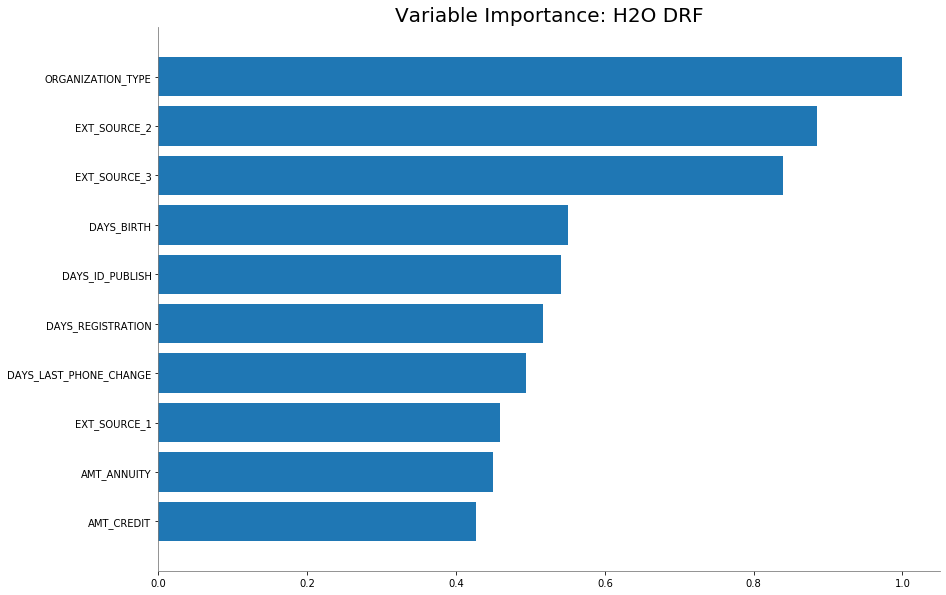

In [106]:
rf.varimp_plot()